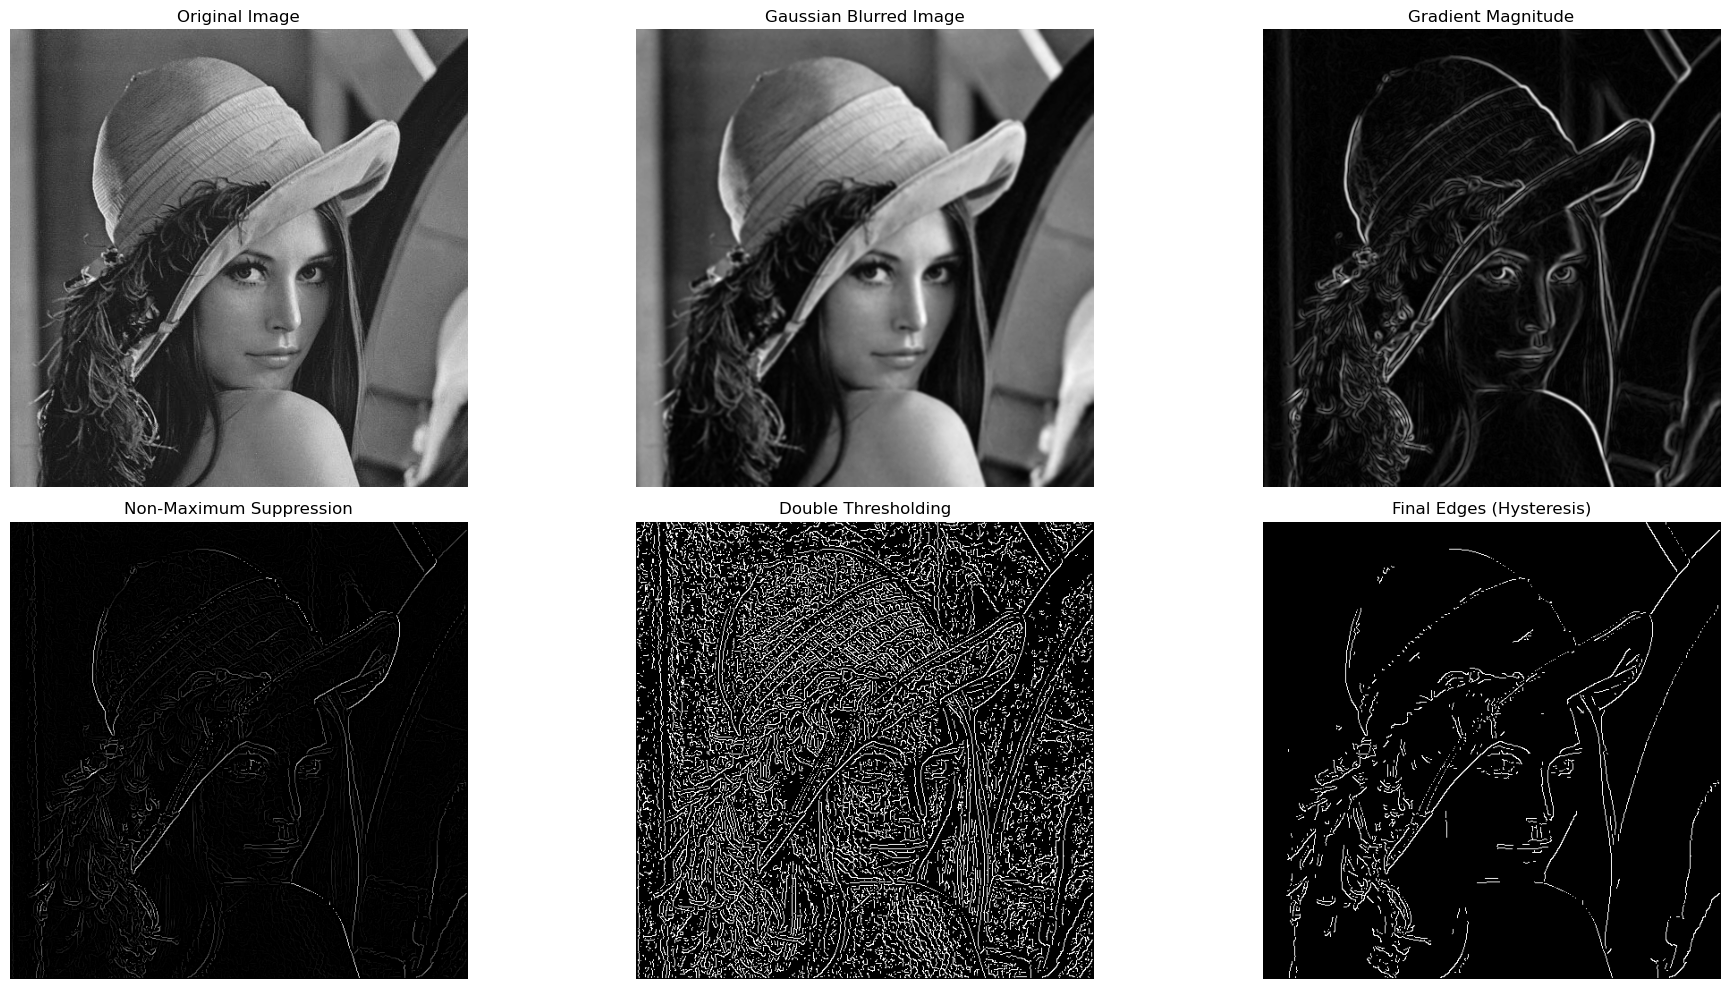

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Path to the image
image_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')

# Load the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Image could not be loaded.")
else:
    # Step 1: Apply Gaussian Blur to smooth the image
    blurred_image = cv2.GaussianBlur(image, (5, 5), sigmaX=1.4)

    # Step 2: Compute gradient in x and y directions
    gradient_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute gradient magnitude and direction
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    gradient_direction = np.abs(gradient_direction) % 180  # Normalize angles to [0, 180]

    # Step 3: Non-Maximum Suppression
    def non_maximum_suppression(magnitude, direction):
        """Suppress non-maximum pixels to thin edges."""
        nms_result = np.zeros_like(magnitude)
        rows, cols = magnitude.shape
        
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                # Determine the two neighboring pixels to compare
                angle = direction[i, j]
                
                if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                    neighbors = (magnitude[i, j - 1], magnitude[i, j + 1])  # Horizontal
                elif 22.5 <= angle < 67.5:
                    neighbors = (magnitude[i - 1, j + 1], magnitude[i + 1, j - 1])  # Diagonal \
                elif 67.5 <= angle < 112.5:
                    neighbors = (magnitude[i - 1, j], magnitude[i + 1, j])  # Vertical
                else:  # 112.5 <= angle < 157.5
                    neighbors = (magnitude[i - 1, j - 1], magnitude[i + 1, j + 1])  # Diagonal /

                # Keep pixel only if it's greater than its neighbors
                if magnitude[i, j] >= max(neighbors):
                    nms_result[i, j] = magnitude[i, j]

        return nms_result

    nms_result = non_maximum_suppression(gradient_magnitude, gradient_direction)

    # Step 4: Double Thresholding
    high_threshold = 0.2 * np.max(nms_result)
    low_threshold = 0.1 * high_threshold

    strong_edges = (nms_result >= high_threshold).astype(np.uint8)
    weak_edges = ((nms_result >= low_threshold) & (nms_result < high_threshold)).astype(np.uint8)

    # Step 5: Edge Tracking by Hysteresis
    def hysteresis(strong, weak):
        """Link weak edges to strong edges."""
        result = np.copy(strong)
        rows, cols = strong.shape
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if weak[i, j] == 1:
                    if np.any(strong[i - 1:i + 2, j - 1:j + 2]):
                        result[i, j] = 1
        return result

    final_edges = hysteresis(strong_edges, weak_edges)

    # Plot the results
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(blurred_image, cmap='gray')
    plt.title("Gaussian Blurred Image")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gradient_magnitude, cmap='gray')
    plt.title("Gradient Magnitude")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(nms_result, cmap='gray')
    plt.title("Non-Maximum Suppression")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(strong_edges + weak_edges, cmap='gray')
    plt.title("Double Thresholding")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(final_edges, cmap='gray')
    plt.title("Final Edges (Hysteresis)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
